# Project 4

## Initial setup

In [0]:
#!pip install ydata-profiling
#%restart_python

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Standard Libraries
import io

# External Libraries
import requests
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import trim
from pyspark.sql.functions import to_date
from pyspark.sql.functions import to_number
from pyspark.sql.types import DateType
from pyspark.sql.types import DecimalType

/databricks/python/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/databricks/python/lib/python3.11/site-packages/visions/backends/shared/nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


## Load the data

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

filePath = "dbfs:/FileStore/shared_uploads/michael.wacey@gwu.edu/loan_data_project4.csv"
rawLoanDF = spark.read.option("header", True).option("inferSchema", True).csv(filePath)


## Review the data

### List all the features

In [0]:
rawLoanDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [0]:
rawLoanDF.columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

Set 1
Reduce the set down to a reasonable number of features. I ran some tests that took more than an hour to complete so they were canceled. So, I reduced the features down to four and will add some back as I need them.

Set 2
At first I had assumed that these were Mortgage Loans. But after looking at the first few rows, they areclearly not. Ther term is too short and the amount is too small. So, I have added in purpose to see what we have.

Set 3
Now I am interested in how old the loans are. The ussue date column is a string with Month and Year. I will have to convert this to a date.

Set 4
Adding in remaining columns of interest to be used in the modeling phase.

In [0]:
columnsToKeep =  [
 'id',          # set 4
 'member_id',   # set 4
 "loan_amnt",   # set 1
 #'funded_amnt',
 #'funded_amnt_inv',
 "term",        # set 1
 'int_rate',    # set 1
 'installment', # set 1
 #'grade',
 #'sub_grade',
 #'emp_title',
 #'emp_length',
 #'home_ownership',
 #'annual_inc',
 #'verification_status',
 'issue_d',     # set 3
 'loan_status', # set 4
 #'pymnt_plan',
 #'url',
 #'desc',
 'purpose',       # set 2
 #'title',
 #'zip_code',
 #'addr_state',
 'dti',         # set 4
 #'delinq_2yrs',
 #'earliest_cr_line',
 'fico_range_low',   # set 4
 'fico_range_high',  # set 4
 #'inq_last_6mths',
 #'mths_since_last_delinq',
 #'mths_since_last_record',
 #'open_acc',
 #'pub_rec',
 'revol_bal',        # set 4
 'revol_util',       # set 4
 #'total_acc',
 #'initial_list_status',
 'out_prncp',          # set 4
 #'out_prncp_inv',
 #'total_pymnt',
 #'total_pymnt_inv',
 #'total_rec_prncp',
 #'total_rec_int',
 #'total_rec_late_fee',
 #'recoveries',
 #'collection_recovery_fee',
 'last_pymnt_d',       # set 4
 'last_pymnt_amnt',    # set 4
 'next_pymnt_d'        # set 4 
 #'last_credit_pull_d',
 #'last_fico_range_high',
 #'last_fico_range_low',
 #'collections_12_mths_ex_med',
 #'mths_since_last_major_derog',
 #'policy_code',
 #'application_type',
 #'annual_inc_joint',
 #'dti_joint',
 #'verification_status_joint',
 #'acc_now_delinq',
 #'tot_coll_amt',
 #'tot_cur_bal',
 #'open_acc_6m',
 #'open_act_il',
 #'open_il_12m',
 #'open_il_24m',
 #'mths_since_rcnt_il',
 #'total_bal_il',
 #'il_util',
 #'open_rv_12m',
 #'open_rv_24m',
 #'max_bal_bc',
 #'all_util',
 #'total_rev_hi_lim',
 #'inq_fi',
 #'total_cu_tl',
 #'inq_last_12m',
 #'acc_open_past_24mths',
 #'avg_cur_bal',
 #'bc_open_to_buy',
 #'bc_util',
 #'chargeoff_within_12_mths',
 #'delinq_amnt',
 #'mo_sin_old_il_acct',
 #'mo_sin_old_rev_tl_op',
 #'mo_sin_rcnt_rev_tl_op',
 #'mo_sin_rcnt_tl',
 #'mort_acc',
 #'mths_since_recent_bc',
 #'mths_since_recent_bc_dlq',
 #'mths_since_recent_inq',
 #'mths_since_recent_revol_delinq',
 #'num_accts_ever_120_pd',
 #'num_actv_bc_tl',
 #'num_actv_rev_tl',
 #'num_bc_sats',
 #'num_bc_tl',
 #'num_il_tl',
 #'num_op_rev_tl',
 #'num_rev_accts',
 #'num_rev_tl_bal_gt_0',
 #'num_sats',
 #'num_tl_120dpd_2m',
 #'num_tl_30dpd',
 #'num_tl_90g_dpd_24m',
 #'num_tl_op_past_12m',
 #'pct_tl_nvr_dlq',
 #'percent_bc_gt_75',
 #'pub_rec_bankruptcies',
 #'tax_liens',
 #'tot_hi_cred_lim',
 #'total_bal_ex_mort',
 #'total_bc_limit',
 #'total_il_high_credit_limit',
 #'revol_bal_joint',
 #'sec_app_fico_range_low',
 #'sec_app_fico_range_high',
 #'sec_app_earliest_cr_line',
 #'sec_app_inq_last_6mths',
 #'sec_app_mort_acc',
 #'sec_app_open_acc',
 #'sec_app_revol_util',
 #'sec_app_open_act_il',
 #'sec_app_num_rev_accts',
 #'sec_app_chargeoff_within_12_mths',
 #'sec_app_collections_12_mths_ex_med',
 #'sec_app_mths_since_last_major_derog',
 #'hardship_flag',
 #'hardship_type',
 #'hardship_reason',
 #'hardship_status',
 #'deferral_term',
 #'hardship_amount',
 #'hardship_start_date',
 #'hardship_end_date',
 #'payment_plan_start_date',
 #'hardship_length',
 #'hardship_dpd',
 #'hardship_loan_status',
 #'orig_projected_additional_accrued_interest',
 #'hardship_payoff_balance_amount',
 #'hardship_last_payment_amount',
 #'disbursement_method',
 #'debt_settlement_flag',
 #'debt_settlement_flag_date',
 #'settlement_status',
 #'settlement_date',
 #'settlement_amount',
 #'settlement_percentage',
 #'settlement_term'
 ]
 
limitLoanDF = rawLoanDF.select(columnsToKeep)
limitLoanDF.cache().count()
display(limitLoanDF)

id member_id loan_amnt term int_rate installment issue_d loan_status purpose dti fico_range_low fico_range_high revol_bal revol_util out_prncp last_pymnt_d last_pymnt_amnt next_pymnt_d 68407277 null 3600.0 36 months 13.99 123.03 Dec-2015 Fully Paid debt_consolidation 5.91 675.0 679.0 2765.0 29.7 0.0 Jan-2019 122.67 null 68355089 null 24700.0 36 months 11.99 820.28 Dec-2015 Fully Paid small_business 16.06 715.0 719.0 21470.0 19.2 0.0 Jun-2016 926.35 null 68341763 null 20000.0 60 months 10.78 432.66 Dec-2015 Fully Paid home_improvement 10.78 695.0 699.0 7869.0 56.2 0.0 Jun-2017 15813.3 null 66310712 null 35000.0 60 months 14.85 829.9 Dec-2015 Current debt_consolidation 17.06 785.0 789.0 7802.0 11.6 15897.65 Feb-2019 829.9 Apr-2019 68476807 null 10400.0 60 months 22.45 289.91 Dec-2015 Fully Paid major_purchase 25.37 695.0 699.0 21929.0 64.5 0.0 Jul-2016 10128.96 null 68426831 null 11950.0 36 months 13.44 405.18 Dec-2015 Fully Paid debt_consolidation 10.2 690.0 694.0 8822.0 68.4 0.0 May-2017 7653.56 null 68476668 null 20000.0 36 months 9.17 637.58 Dec-2015 Fully Paid debt_consolidation 14.67 680.0 684.0 87329.0 84.5 0.0 Nov-2016 15681.05 null 67275481 null 20000.0 36 months 8.49 631.26 Dec-2015 Fully Paid major_purchase 17.61 705.0 709.0 826.0 5.7 0.0 Jan-2017 14618.23 null 68466926 null 10000.0 36 months 6.49 306.45 Dec-2015 Fully Paid credit_card 13.07 685.0 689.0 10464.0 34.5 0.0 Aug-2018 1814.48 null 68616873 null 8000.0 36 months 11.48 263.74 Dec-2015 Fully Paid credit_card 34.8 700.0 704.0 7034.0 39.1 0.0 Apr-2017 4996.24 null 68356421 null 22400.0 60 months 12.88 508.3 Dec-2015 Current debt_consolidation 22.98 710.0 714.0 13028.0 32.7 9912.88 Feb-2019 508.3 Apr-2019 68426545 null 16000.0 60 months 12.88 363.07 Dec-2015 Current debt_consolidation 26.4 720.0 724.0 28705.0 56.3 7080.7 Feb-2019 363.07 Apr-2019 68338832 null 1400.0 36 months 12.88 47.1 Dec-2015 Fully Paid other 34.95 700.0 704.0 37828.0 67.2 0.0 Mar-2017 965.36 null 66624733 null 18000.0 60 months 19.48 471.7 Dec-2015 Charged Off debt_consolidation 9.39 665.0 669.0 14052.0 40.7 0.0 May-2017 471.7 null 68466961 null 28000.0 36 months 6.49 858.05 Dec-2015 Fully Paid debt_consolidation 21.6 720.0 724.0 51507.0 64.5 0.0 May-2017 17093.51 null 68354783 null 9600.0 36 months 7.49 298.58 Dec-2015 Fully Paid credit_card 22.44 695.0 699.0 7722.0 59.4 0.0 Feb-2018 3480.17 null 68466916 null 25000.0 36 months 7.49 777.55 Dec-2015 Fully Paid debt_consolidation 26.02 745.0 749.0 20862.0 54.3 0.0 Sep-2016 20807.39 null 68577849 null 18000.0 60 months 11.99 400.31 Dec-2015 Fully Paid debt_consolidation 8.68 800.0 804.0 10711.0 15.5 0.0 Mar-2016 18004.9 null 68506798 null 23000.0 60 months 8.49 471.77 Dec-2015 Current credit_card 18.28 700.0 704.0 24940.0 52.7 9580.2 Feb-2019 471.77 Apr-2019 68495092 null 8650.0 36 months 19.89 320.99 Dec-2015 Fully Paid debt_consolidation 25.49 675.0 679.0 9568.0 46.0 0.0 May-2016 8251.42 null 68566886 null 29900.0 60 months 12.88 678.49 Dec-2015 Fully Paid debt_consolidation 21.77 715.0 719.0 31682.0 46.7 0.0 Mar-2017 25234.24 null 68009401 null 16000.0 60 months 14.85 379.39 Dec-2015 Fully Paid credit_card 33.18 685.0 689.0 19108.0 29.6 0.0 Sep-2017 12322.68 null 68476702 null 28000.0 36 months 13.44 949.38 Dec-2015 Fully Paid debt_consolidation 7.49 695.0 699.0 22780.0 63.1 0.0 Dec-2017 12486.3 null 68436666 null 5000.0 36 months 13.44 169.54 Dec-2015 Fully Paid credit_card 12.7 665.0 669.0 9441.0 101.5 0.0 Jan-2019 169.17 null 68476715 null 6000.0 36 months 7.49 186.61 Dec-2015 Fully Paid debt_consolidation 13.28 695.0 699.0 8563.0 72.0 0.0 Jan-2019 186.6 null 67849662 null 4225.0 36 months 14.85 146.16 Dec-2015 Charged Off debt_consolidation 15.22 725.0 729.0 1058.0 24.6 0.0 Apr-2017 146.16 null 68596180 null 20000.0 36 months 5.32 602.3 Dec-2015 Fully Paid debt_consolidation 18.83 835.0 839.0 2269.0 3.0 0.0 Aug-2018 3577.5 null 68526907 null 16000.0 60 months 17.97 406.04 Dec-2015 Fully Paid debt_consolidation 23.35 680.0 684.0 42469.0 8

Fix any features. Most of these fixes were identified later but added back in here.

In [0]:
# Fix 1 is to convert the term to a number of months
# This took me forever (forever means 3-4 hours) to figure out. Doing things like this should be easier, I don't understand why Python, Spark, etc. make it so complicated.
fix1LoanDF = limitLoanDF.withColumn("term_months",when(trim(limitLoanDF["term"]) == "36 months",36)
                                                    .when(trim(limitLoanDF["term"]) == "60 months",60).otherwise(0))
# Fix 2 is to convert the issue date from a string to a date
fix2LoanDF = fix1LoanDF.withColumn("issue_date", to_date(fix1LoanDF["issue_d"], "MMM-yyyy").cast(DateType()))
# Fix 3 is to convert the last payment date from a string to a date
fix3LoanDF = fix2LoanDF.withColumn("last_payment_date", to_date(fix2LoanDF["last_pymnt_d"], "MMM-yyyy").cast(DateType()))
# Fix 4 is to convert the outstanding principal from a string to a number
fix4LoanDF = fix3LoanDF.withColumn("outstanding_principle", fix3LoanDF["out_prncp"].cast(DecimalType(18,2)))

# Set the name to a common name so that next steps know what to use
baseLoanDF = fix4LoanDF
baseLoanDF.createOrReplaceTempView("baseLoanDF")

### Get the basic statistics for each feature

In [0]:
display(baseLoanDF.describe())

summary id member_id loan_amnt term int_rate installment issue_d loan_status purpose dti fico_range_low fico_range_high revol_bal revol_util last_pymnt_d last_pymnt_amnt next_pymnt_d termMonthts count 2260701 0 2260668 2260668 2260668 2260668 2260668 2260668 2260667 2258956 2260667 2260667 2260614 2258834 2258234 2260665 915582 2260701 mean 8.032205972323003E7 null 15046.931227849467 null 13.092829115115324 445.80682288154975 null null 384.0 18.824907147958026 698.5605010090696 702.5678527699907 16657.354743919248 50.865374118007324 1992.819882899532 3429.3679155921786 2652.191162115283 42.909692170702805 stddev 4.4985611312901564E7 null 9190.245488232755 null 4.832138364571108 267.1735346084259 null null 543.0580079512685 14.183773199305032 33.281001525998875 33.21178665565209 22948.04685404851 185.31754349077312 4899.91488926413 6018.383192521175 5252.427202736087 10.868318568000499 min 1000007 null 500.0 36 months 5.31 4.93 Apr-2008 Charged Off After graduating from college Karen " 809 Capital One ($2768) and Discover($1490). I always pay more than the minimum payments and the work we do. We are in the marketing research and consulting business. Our main task is to speak with customers I am working on that as well. I do have about $30K in IRA's and have checking & savings set up. I am not in school so have no student loans 0.0 0.0 0.0 0 max Total amount funded in policy code 2: 873652739 null 40000.0 60 months 30.99 1719.83 Source Verified Oct-2015 wedding wedding small_business wedding small_business other f f f 60

Note that the term and issue_d (Issue data) have null values. This will need to be looked into to determine what needs to be done.

## Profile the data

In [0]:
report = ProfileReport(limitLoanDF,
                title='Loan Data',
                infer_dtypes=False,
                interactions=None,
                missing_diagrams=None,
                correlations={"auto": {"calculate": False},
                              "pearson": {"calculate": True},
                              "spearman": {"calculate": True}})

report_html = report.to_html()
displayHTML(report_html)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/databricks/python/lib/python3.11/site-packages/ydata_profiling/model/spark/sample_spark.py:33: UserWarning: tail sample not implemented for spark. Set config.samples.n_tail to 0 to disable this warning
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<!doctype html> Loan Data Toggle navigation Loan Data Overview Variables Correlations Sample Duplicate rows Overview Overview Alerts 15 Reproduction Dataset statistics Number of variables 16 Number of observations 2260701 Missing cells 1351572 Missing cells (%) 3.7% Duplicate rows 1 Duplicate rows (%) < 0.1% Variable types Numeric 3 Categorical 13 Alerts Dataset has 1 (< 0.1%) duplicate rows Duplicates issue_d has a high cardinality: 141 distinct values High cardinality purpose has a high cardinality: 269 distinct values High cardinality dti has a high cardinality: 11052 distinct values High cardinality fico_range_low has a high cardinality: 246 distinct values High cardinality fico_range_high has a high cardinality: 221 distinct values High cardinality revol_bal has a high cardinality: 102287 distinct values High cardinality revol_util has a high cardinality: 1541 distinct values High cardinality out_prncp has a high cardinality: 356240 distinct values High cardinality last_pymnt_d has a high cardinality: 229 distinct values High cardinality last_pymnt_amnt has a high cardinality: 704488 distinct values High cardinality next_pymnt_d has a high cardinality: 223 distinct values High cardinality loan_amnt is highly overall correlated with installment High correlation installment is highly overall correlated with loan_amnt High correlation next_pymnt_d has 1345119 (59.5%) missing values Missing Reproduction Analysis started 2024-06-02 13:59:37.190631 Analysis finished 2024-06-02 14:09:36.466573 Duration 9 minutes and 59.28 seconds Software version ydata-profiling vv4.5.1 Download configuration <a download=config.json href="data:text/plain;charset=utf-8,%7B%22title%22%3A%20%22Loan%20Data%22%2C%20%22dataset%22%3A%20%7B%22description%22%3A%20%22%22%2C%20%22creator%22%3A%20%22%22%2C%20%22author%22%3A%20%22%22%2C%20%22copyright_holder%22%3A%20%22%22%2C%20%22copyright_year%22%3A%20%22%22%2C%20%22url%22%3A%20%22%22%7D%2C%20%22variables%22%3A%20%7B%22descriptions%22%3A%20%7B%7D%7D%2C%20%22infer_dtypes%22%3A%20false%2C%20%22show_variable_description%22%3A%20true%2C%20%22pool_size%22%3A%200%2C%20%22progress_bar%22%3A%20true%2C%20%22vars%22%3A%20%7B%22num%22%3A%20%7B%22quantiles%22%3A%20%5B0.05%2C%200.25%2C%200.5%2C%200.75%2C%200.95%5D%2C%20%22skewness_threshold%22%3A%2020%2C%20%22low_categorical_threshold%22%3A%205%2C%20%22chi_squared_threshold%22%3A%200.999%7D%2C%20%22text%22%3A%20%7B%22length%22%3A%20true%2C%20%22words%22%3A%20true%2C%20%22characters%22%3A%20true%2C%20%22redact%22%3A%20false%2C%20%22categorical_threshold%22%3A%2050%2C%20%22percentage_cat_threshold%22%3A%200.5%7D%2C%20%22cat%22%3A%20%7B%22length%22%3A%20true%2C%20%22characters%22%3A%20true%2C%20%22words%22%3A%20true%2C%20%22cardinality_threshold%22%3A%2050%2C%20%22imbalance_threshold%22%3A%200.5%2C%20%22n_obs%22%3A%205%2C%20%22chi_squared_threshold%22%3A%200.999%2C%20%22coerce_str_to_date%22%3A%20false%2C%20%22redact%22%3A%20false%2C%20%22histogram_largest%22%3A%2050%2C%20%22stop_words%22%3A%20%5B%5D%7D%2C%20%22image%22%3A%20%7B%22active%22%3A%20false%2C%20%22exif%22%3A%20true%2C%20%22hash%22%3A%20true%7D%2C%20%22bool%22%3A%20%7B%22n_obs%22%3A%203%2C%20%22imbalance_threshold%22%3A%200.5%2C%20%22mappings%22%3A%20%7B%22t%22%3A%20true%2C%20%22f%22%3A%20false%2C%20%22yes%22%3A%20true%2C%20%22no%22%3A%20false%2C%20%22y%22%3A%20true%2C%20%22n%22%3A%20false%2C%20%22true%22%3A%20true%2C%20%22false%22%3A%20false%7D%7D%2C%20%22path%22%3A%20%7B%22active%22%3A%20false%7D%2C%20%22file%22%3A%20%7B%22active%22%3A%20false%7D%2C%20%22url%22%3A%20%7B%22active%22%3A%20false%7D%2C%20%22timeseries%22%3A%20%7B%22active%22%3A%20false%2C%20%22sortby%22%3A%20null%2C%20%22autocorrelation%22%3A%200.7%2C%20%22lags%22%3A%20%5B1%2C%207%2C%2012%2C%2024%2C%2030%5D%2C%20%22significance%22%3A%200.05%2C%20%22pacf_acf_lag%22%3A%20100%7D%7D%2C%20%22sort%22%3A%20null%2C%20%22missing_diagrams%22%3A%20%7B%22bar%22%3A%20false%2C%20%22matrix%22%3A%20false%2C%20%22heatmap%22%3A%20false%7D%2C%20%22correlation_table

# Part 1: Data Exploration and Analysis

Explore the dataset and create FOUR analysis questions of varying complexity. Use Spark DataFrame API and SparkSQL to answer them (any other visualization tools can be used). Ensure the questions cover different aspects of the data.

Questions under consideration.
* How many features have missing data and how much missing data?
* Is the data as of the loan origination or is it updated throughout the loan?
* What are the loan count and the loan amount by purpose.

## Question 1: What are the loan count and loan amount by purpose?

This started simple but took a little bit of doing. There were many purposes that only had one instance and I wanted to group them togeather. This took two levels of query. Then I had to format the results to make them readable. The results are nice.

In [0]:
baseLoanDF.createOrReplaceTempView("baseLoanDF")
sqlCMD =  " select"
sqlCMD += "   Purpose"
sqlCMD += "   , to_char(sum(RowCount),'999,999,999') as RowCount"
sqlCMD += "   , to_char(sum(TotalLoanAmount),'$999,999,999,999') as TotalLoanAmount"
sqlCMD += "   , to_char(cast(sum(TotalLoanAmount) / sum(RowCount) as decimal(12)),'$999,999') as AverageLoanAmount"
sqlCMD += " from"
sqlCMD += "   (select"
sqlCMD += "    if(RowCount = 1, 'Other', Purpose) as Purpose"
sqlCMD += "    , RowCount"
sqlCMD += "    , TotalLoanAmount"
sqlCMD += "   from"
sqlCMD += "    (SELECT"
sqlCMD += "       purpose as Purpose"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       Purpose))"
sqlCMD += "    GROUP BY"
sqlCMD += "       purpose"
sqlCMD += " order by 2 desc"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+------------------+-----------+----------------+-----------------+
|           Purpose|   RowCount| TotalLoanAmount|AverageLoanAmount|
+------------------+-----------+----------------+-----------------+
|debt_consolidation|  1,277,790|$ 20,402,423,625|         $ 15,967|
|       credit_card|    516,926|$  7,919,283,900|         $ 15,320|
|  home_improvement|    150,440|$  2,206,393,325|         $ 14,666|
|             other|    139,413|$  1,461,233,450|         $ 10,481|
|    major_purchase|     50,429|$    639,650,250|         $ 12,684|
|           medical|     27,481|$    260,365,250|         $  9,474|
|    small_business|     24,659|$    405,529,900|         $ 16,446|
|               car|     24,009|$    225,535,200|         $  9,394|
|          vacation|     15,525|$     98,707,875|         $  6,358|
|            moving|     15,402|$    129,231,175|         $  8,391|
|             house|     14,131|$    221,921,475|         $ 15,705|
|           wedding|      2,351|$     24,636,975

<Axes: xlabel='Purpose'>

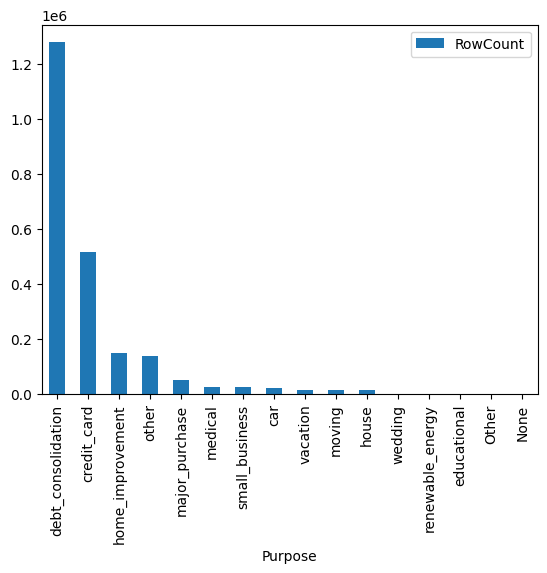

In [0]:
baseLoanDF.createOrReplaceTempView("baseLoanDF")
sqlCMD =  " select"
sqlCMD += "   Purpose"
sqlCMD += "   , sum(RowCount) as RowCount"
sqlCMD += "   , to_char(sum(TotalLoanAmount),'$999,999,999,999') as TotalLoanAmount"
sqlCMD += "   , to_char(cast(sum(TotalLoanAmount) / sum(RowCount) as decimal(12)),'$999,999') as AverageLoanAmount"
sqlCMD += " from"
sqlCMD += "   (select"
sqlCMD += "    if(RowCount = 1, 'Other', Purpose) as Purpose"
sqlCMD += "    , RowCount"
sqlCMD += "    , TotalLoanAmount"
sqlCMD += "   from"
sqlCMD += "    (SELECT"
sqlCMD += "       purpose as Purpose"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       Purpose))"
sqlCMD += "    GROUP BY"
sqlCMD += "       purpose"
sqlCMD += " order by 2 desc"
sqlDF = spark.sql(sqlCMD)
#sqlDF.show()
aDF = sqlDF.toPandas()
#print(aDF)
aDF.plot.bar(x='Purpose',y='RowCount')

The results show that debt_consolidation is the most common loan. It is also the most loan amount. Looking at the average, small_buiseness has the highest average value, followed by debt_conolidation, and credit_card.

Note that even though the values are out of balance, it is not nesccerry to rebalance the data. Since we are looking to predict loan status, it should be predicted by purpose, not accross purposes. This is because borrowers will act differently based upon the purpose of the loan. People will always pay their Mortgage but may defer car payments if money is tight.

## Question 2: What are the loan counts and amounts by term, loan date, and age.
This is differnet than question one. In question 1, I had to figure out how to group the set of values bsed on number of rows. Here I will need to find out how many null values there are and also convert strings to dates and so some date arithmatic.

In [0]:
# This query told me that only 33 rows had a null term. So, I will just exclude them.
sqlCMD = "    SELECT"
sqlCMD += "       term as Term"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       term"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+----------+--------+---------------+
|      Term|RowCount|TotalLoanAmount|
+----------+--------+---------------+
| 36 months| 1609754|2.0517162875E10|
| 60 months|  650914| 1.349895305E10|
|      NULL|      33|           NULL|
+----------+--------+---------------+



In [0]:
# based on this query, the same 33 rows have a null issue date. There is also one row with 'Source Verified' 
# as the issue_d. I will ignore that one too.
sqlCMD = "    SELECT"
sqlCMD += "       term as Term"
sqlCMD += "       , issue_d as LoanDate"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     WHERE"
sqlCMD += "       issue_d is null"
sqlCMD += "     GROUP BY"
sqlCMD += "       term"
sqlCMD += "       , issue_d"
sqlCMD += "     ORDER BY"
sqlCMD += "       issue_d DESC"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+----+--------+--------+---------------+
|Term|LoanDate|RowCount|TotalLoanAmount|
+----+--------+--------+---------------+
|NULL|    NULL|      33|           NULL|
+----+--------+--------+---------------+



In [0]:
baseLoanDF.createOrReplaceTempView("baseLoanDF")
sqlCMD = "    SELECT"
#sqlCMD += "       term as Term"
#sqlCMD += "       , issue_d as LoanDate"
#sqlCMD += "       , issue_date as IssueDate"
sqlCMD += "       year(issue_date) as IssueYear"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     WHERE"
sqlCMD += "       term is not null"
sqlCMD += "       and issue_d is not null"
sqlCMD += "       and issue_d <> 'Source Verified'"
sqlCMD += "     GROUP BY"
sqlCMD += "       year(issue_date)"
#sqlCMD += "       term"
#sqlCMD += "       , issue_d"
#sqlCMD += "       , issue_date"
sqlCMD += "     ORDER BY"
sqlCMD += "       1"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+---------+--------+---------------+
|IssueYear|RowCount|TotalLoanAmount|
+---------+--------+---------------+
|     2007|     603|      4977475.0|
|     2008|    2393|     2.111925E7|
|     2009|    5281|     5.192825E7|
|     2010|   12537|    1.3199255E8|
|     2011|   21721|   2.61683825E8|
|     2012|   53367|   7.18411025E8|
|     2013|  134814|  1.982765275E9|
|     2014|  235629|  3.503840175E9|
|     2015|  421094|  6.417597675E9|
|     2016|  434407|    6.4005697E9|
|     2017|  443579|  6.584957075E9|
|     2018|  495242|   7.93626315E9|
+---------+--------+---------------+



<Axes: xlabel='IssueYear'>

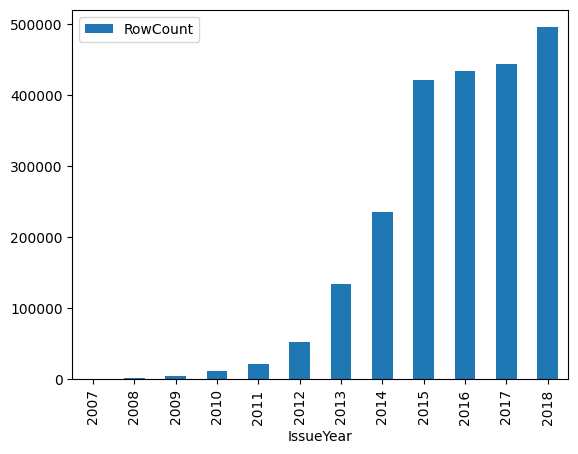

In [0]:
aDF = sqlDF.toPandas()
#print(aDF)
aDF.plot.bar(x='IssueYear',y='RowCount')

Based on this I added columns for term in months and the loan origination date. Since the date only has month and year, I used the first of the year. I also know to ignore the 33 rows with null values for term and loan date.

Clearly, they have started small in 2007 and grew rapidly over the years.

## Question 3: Are Loan IDs Unique?
I have been assuming that we only have one row per loan. I want to verify this.

In [0]:
# Count the rows by the loan id and keep any where the number of rows is greater than one
sqlCMD = "    SELECT"
sqlCMD += "       id as LoanID"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       id"
sqlCMD += "     HAVING"
sqlCMD += "       count(*) > 1"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+------+--------+---------------+
|LoanID|RowCount|TotalLoanAmount|
+------+--------+---------------+
+------+--------+---------------+



Based on this, we only have one row per loan. This confirms my expectation. I am going to check the same thing by member id. I think there will be duplicates since a person can have multiple loans. I also noticed that there are NULLS. 

In [0]:
# Count the rows by the loan id and keep any where the number of rows is greater than one
sqlCMD = "    SELECT"
sqlCMD += "       member_id as MemberID"
sqlCMD += "       , count(*) as RowCount"
sqlCMD += "       , sum(loan_amnt) as TotalLoanAmount"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       member_id"
sqlCMD += "     HAVING"
sqlCMD += "       count(*) > 1"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+--------+--------+---------------+
|MemberID|RowCount|TotalLoanAmount|
+--------+--------+---------------+
|    NULL| 2260701|3.4016115925E10|
+--------+--------+---------------+



Interesting. So, the member IDs are all null. The use of the term member_id, makes me think that this is a credit union since they typically refer to their customers as members. It could also be a mutual insurance company that is entering the banking industry but I think that is less likly.

## Question 4: What are the dates of most recent payments?
I am trying to understand when this file was created.

In [0]:
# First lets look at the minimum and maximum last payment dates.
sqlCMD = "    SELECT"
sqlCMD += "       min(last_payment_date)"
sqlCMD += "       , max(last_payment_date)"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+----------------------+----------------------+
|min(last_payment_date)|max(last_payment_date)|
+----------------------+----------------------+
|            2007-12-01|            2019-03-01|
+----------------------+----------------------+



So, it looks like the data was pulled sometime in March of 2019.

I am curious to know how the last payment date relates to the loan end date. So, with the issue date and term in months, I can calculate the expected loan end date. Then I can calulate the difference in days between the loan end date and the last payment date. For loans that end after March of 2019, this will have to be negative. It will be interesting to see.

In [0]:
sqlCMD = "    SELECT"
sqlCMD += "       add_months(issue_date,term_months) as end_date"
sqlCMD += "       , last_payment_date"
sqlCMD += "       , datediff(last_payment_date,least(add_months(issue_date,term_months), DATE '2019-03-01')) as days_past_due"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+----------+-----------------+-------------+
|  end_date|last_payment_date|days_past_due|
+----------+-----------------+-------------+
|2018-12-01|       2019-01-01|           31|
|2018-12-01|       2016-06-01|         -913|
|2020-12-01|       2017-06-01|         -638|
|2020-12-01|       2019-02-01|          -28|
|2020-12-01|       2016-07-01|         -973|
|2018-12-01|       2017-05-01|         -579|
|2018-12-01|       2016-11-01|         -760|
|2018-12-01|       2017-01-01|         -699|
|2018-12-01|       2018-08-01|         -122|
|2018-12-01|       2017-04-01|         -609|
|2020-12-01|       2019-02-01|          -28|
|2020-12-01|       2019-02-01|          -28|
|2018-12-01|       2017-03-01|         -640|
|2020-12-01|       2017-05-01|         -669|
|2018-12-01|       2017-05-01|         -579|
|2018-12-01|       2018-02-01|         -303|
|2018-12-01|       2016-09-01|         -821|
|2020-12-01|       2016-03-01|        -1095|
|2020-12-01|       2019-02-01|          -28|
|2018-12-0

Just looking at these values, this is more complicated. I would need to take into account the current date (in this case, I would use March 1, 2019 as the current date) and the outstanding balance to see if a loan is past due.

In [0]:
# For this query, I wil us the following definition. A loan is late if the last payment is over 60 late and the end date is after today and the outstanding principal is more than $10.
sqlCMD = "    SELECT"
sqlCMD += "       add_months(issue_date,term_months) as end_date"
sqlCMD += "       , last_payment_date, out_prncp,outstanding_principle"
sqlCMD += "       , datediff(last_payment_date,least(add_months(issue_date,term_months), DATE '2019-03-01')) as days_past_due"
sqlCMD += "       , loan_status"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     WHERE"
sqlCMD += "       datediff(last_payment_date,least(add_months(issue_date,term_months), DATE '2019-03-01')) < -60"
sqlCMD += "       and add_months(issue_date,term_months) > DATE '2019-03-01'"
sqlCMD += "       and outstanding_principle > 10"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+----------+-----------------+---------+---------------------+-------------+------------------+
|  end_date|last_payment_date|out_prncp|outstanding_principle|days_past_due|       loan_status|
+----------+-----------------+---------+---------------------+-------------+------------------+
|2020-12-01|       2018-12-01| 13508.59|             13508.59|          -90|Late (31-120 days)|
|2020-12-01|       2018-12-01| 14200.87|             14200.87|          -90|Late (31-120 days)|
|2020-12-01|       2018-11-01|  5349.48|              5349.48|         -120|Late (31-120 days)|
|2020-12-01|       2018-12-01| 10650.67|             10650.67|          -90|Late (31-120 days)|
|2020-12-01|       2018-12-01|  8684.92|              8684.92|          -90|Late (31-120 days)|
|2020-12-01|       2018-12-01| 15995.55|             15995.55|          -90|Late (31-120 days)|
|2020-12-01|       2018-11-01|  8111.71|              8111.71|         -120|Late (31-120 days)|
|2020-12-01|       2018-12-01| 22038.61|

It looks like there are a lot of past due accounts. And the loan status is consistent with this.

In [0]:
# Let's take a look at loans by loan status
sqlCMD = "    SELECT"
sqlCMD += "       loan_status"
sqlCMD += "       , count(*)"
sqlCMD += "     FROM"
sqlCMD += "       baseLoanDF"
sqlCMD += "     GROUP BY"
sqlCMD += "       loan_status"
sqlDF = spark.sql(sqlCMD)
sqlDF.show()

+--------------------+--------+
|         loan_status|count(1)|
+--------------------+--------+
|          Fully Paid| 1076751|
|             Default|      40|
|     In Grace Period|    8436|
|         Charged Off|  268558|
|            Oct-2015|       1|
|  Late (31-120 days)|   21467|
|             Current|  878317|
|   Late (16-30 days)|    4349|
|                NULL|      33|
|Does not meet the...|    1988|
|Does not meet the...|     761|
+--------------------+--------+



## Create a clean data set

In [0]:
sqlCMD =  " SELECT"
sqlCMD += " loan_amnt"
sqlCMD += ", term"
sqlCMD += ", int_rate"
sqlCMD += ", installment"
sqlCMD += ", issue_d"
sqlCMD += ", loan_status"
sqlCMD += ", purpose"
sqlCMD += ", cast(dti as decimal(12,2))"
sqlCMD += ", cast(fico_range_low as decimal(12,2))"
sqlCMD += ", cast(fico_range_high as decimal(12,2))"
sqlCMD += ", cast(revol_bal as decimal(12,2))"
sqlCMD += ", cast(revol_util as decimal(12,2))"
sqlCMD += ", cast(out_prncp as decimal(12,2))"
sqlCMD += ", last_pymnt_d"
sqlCMD += ", cast(last_pymnt_amnt as decimal(12,2))"
sqlCMD += ", next_pymnt_d"
sqlCMD += ", term_months"
sqlCMD += ", issue_date"
sqlCMD += ", last_payment_date"
sqlCMD += ", outstanding_principle"
sqlCMD += " FROM"
sqlCMD += "  baseLoanDF"
sqlCMD += " WHERE"
sqlCMD += "  issue_d is not null"
cleanDF = spark.sql(sqlCMD)
cleanDF.show()

+---------+----------+--------+-----------+--------+-----------+------------------+-----+--------------+---------------+---------+----------+---------+------------+---------------+------------+-----------+----------+-----------------+---------------------+
|loan_amnt|      term|int_rate|installment| issue_d|loan_status|           purpose|  dti|fico_range_low|fico_range_high|revol_bal|revol_util|out_prncp|last_pymnt_d|last_pymnt_amnt|next_pymnt_d|term_months|issue_date|last_payment_date|outstanding_principle|
+---------+----------+--------+-----------+--------+-----------+------------------+-----+--------------+---------------+---------+----------+---------+------------+---------------+------------+-----------+----------+-----------------+---------------------+
|   3600.0| 36 months|   13.99|     123.03|Dec-2015| Fully Paid|debt_consolidation| 5.91|        675.00|         679.00|  2765.00|     29.70|     0.00|    Jan-2019|         122.67|        NULL|         36|2015-12-01|       2019-0

# Part 2: Data Cleaning and Feature Engineering

This was done in the previous steps based on the EDA, Analysis, and Data Profiling.

# Part 3: Model Development and Evaluation

In [0]:
trainDF, testDF = cleanDF.randomSplit([.8, .2], seed=42)
print(f"There are {trainDF.cache().count()} rows in the training set, and {testDF.cache().count()} in the test set")

There are 1809135 rows in the training set, and 451533 in the test set


In [0]:
from pyspark.ml.feature import RFormula

rFormula = RFormula(formula="loan_status ~ .", featuresCol="features", labelCol="loan_status", handleInvalid="skip")

In [0]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="loan_status", featuresCol="features")

In [0]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [rFormula, lr])

pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "loan_status", "prediction").show(5)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-2324547570891020>, line 5
      1 from pyspark.ml import Pipeline
      3 pipeline = Pipeline(stages = [rFormula, lr])
----> 5 pipelineModel = pipeline.fit(trainDF)
      6 predDF = pipelineModel.transform(testDF)
      7 predDF.select("features", "loan_status", "prediction").show(5)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/python/lib/python3.11/site-packages/mlflow/utils/autologging_utils/safety.py:578, in safe_patch.<locals>.safe_patch_function(*args, **kwargs)
    576     patch_function.call(call_original, *args, **kwargs)
    

In [0]:

categoricalCols = [field for (field, dataType) in trainDF.dtypes 
                   if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
stringIndexer = StringIndexer(inputCols=categoricalCols, 
                              outputCols=indexOutputCols, 
                              handleInvalid="skip")

numericCols = [field for (field, dataType) in trainDF.dtypes 
               if ((dataType == "double") )]
assemblerInputs = indexOutputCols + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, 
                               outputCol="features")

rf = RandomForestRegressor(labelCol="loan_statusIndex", maxBins=40, maxDepth=5, 
                           numTrees=100, seed=42)

pipeline = Pipeline(stages=[stringIndexer, vecAssembler, rf])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("features", "loan_statusIndex", "prediction").show(5)


---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-3969238600131509>, line 18
     14 rf = RandomForestRegressor(labelCol="loan_statusIndex", maxBins=40, maxDepth=5, 
     15                            numTrees=100, seed=42)
     17 pipeline = Pipeline(stages=[stringIndexer, vecAssembler, rf])
---> 18 pipelineModel = pipeline.fit(trainDF)
     19 predDF = pipelineModel.transform(testDF)
     20 predDF.select("features", "loan_statusIndex", "prediction").show(5)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py:30, in _create_patch_function.<locals>.patched_method(self, *args, **kwargs)
     28 call_succeeded = False
     29 try:
---> 30     result = original_method(self, *args, **kwargs)
     31     call_succeeded = True
     32     return result

File /databricks/python/lib/python3.11/site-packages/mlflow/utils/autologging_utils/safety.py:578